In [134]:
import re
import pandas as pd
from datetime import datetime
from transformers import pipeline
import matplotlib.pyplot as plt

In [135]:
POC_NAME = "TADA ALBORADA"


In [136]:
ruta_archivo = './chats/gye.txt'

In [137]:
patron_linea = re.compile(
    r'^(\d{1,2}/\d{1,2}/\d{4}), (\d{1,2}:\d{2}) - (.*?): (.*)$'
)

In [138]:
datos = []
ultima_fecha = None
ultima_hora = None
ultima_persona = None
ultimo_mensaje = []

In [139]:
with open(ruta_archivo, 'r', encoding='utf-8') as f:
    for linea in f:
        linea = linea.strip()

        match = patron_linea.match(linea)
        if match:
            # Si hay un mensaje anterior sin cerrar, lo guardamos
            if ultima_fecha and ultima_persona is not None:
                datos.append([
                    ultima_fecha,
                    ultima_hora,
                    ultima_persona,
                    "\n".join(ultimo_mensaje)
                ])

            # Extraemos datos de la nueva línea
            fecha_str = match.group(1)  # "DD/MM/YYYY"
            hora_str = match.group(2)  # "HH:MM"
            persona = match.group(3)
            mensaje = match.group(4)

            # Convertimos a datetime
            try:
                fecha_hora = datetime.strptime(
                    f"{fecha_str} {hora_str}",
                    "%d/%m/%Y %H:%M"
                )
            except ValueError:
                # Si falla el parseo, podemos ignorar la línea o manejarla
                continue

            # Guardamos temporalmente para multiline
            ultima_fecha = fecha_hora.date()
            ultima_hora = fecha_hora.time()
            ultima_persona = persona
            ultimo_mensaje = [mensaje]

        else:
            # Es la continuación (siguiente línea) del mensaje anterior
            if ultima_persona is not None:
                ultimo_mensaje.append(linea)

# Agregamos el último mensaje si quedó pendiente
if ultima_fecha and ultima_persona is not None:
    datos.append([
        ultima_fecha,
        ultima_hora,
        ultima_persona,
        "\n".join(ultimo_mensaje)
    ])

In [140]:
# ==========================================================================
# 2. Construir DataFrame completo de todos los chats
# ==========================================================================
df_chats = pd.DataFrame(datos, columns=['Fecha', 'Hora', 'Persona', 'Mensaje'])

# Creamos una columna de tipo datetime completa
df_chats['FechaHora'] = df_chats.apply(
    lambda x: datetime.combine(x['Fecha'], x['Hora']), axis=1
)

# Ordenamos el DataFrame por fecha-hora por si no viniese ordenado
df_chats.sort_values(by='FechaHora', inplace=True, ignore_index=True)

In [141]:
# ==========================================================================
# 3. DataFrame con integrantes únicos (df_integrantes)
# ==========================================================================
integrantes_unicos = df_chats['Persona'].unique().tolist()
df_integrantes = pd.DataFrame({'Integrante': integrantes_unicos})

In [142]:
# ==========================================================================
# 4. Identificación de asesores
# ==========================================================================
# Paso 1: Detectar usuarios que enviaron la frase clave
asesores = df_chats[df_chats['Mensaje'].str.contains(
    "Me pongo a sus órdenes", case=False, na=False
)]['Persona'].unique()

# Paso 2: Crear una nueva columna `EsAsesor`
df_chats['EsAsesor'] = df_chats['Persona'].isin(asesores)

In [143]:
# ==========================================================================
# 5. DataFrame con chats filtrados (df_chats_filtrados)
#    Reglas:
#      - Incluir TADA ALBORADA (tienda).
#      - Incluir asesores en todos sus mensajes.
#      - Excluir el resto.
# ==========================================================================
def es_tienda(row):
    return "TADA ALBORADA" in row['Persona'].upper()

def cambiar_nombre_tienda(row):
    return "TIENDA" if POC_NAME in row['Persona'].upper() else row['Persona']

# Filtro de tienda o asesores
df_chats_filtrados = df_chats[df_chats.apply(
    lambda x: es_tienda(x) or x['EsAsesor'], axis=1
)].copy()

df_chats_filtrados['Persona'] = df_chats_filtrados.apply(
    cambiar_nombre_tienda, axis=1)

# ==========================================================================
# 6. Eliminar filas con "Multimedia omitido"
# ==========================================================================
df_chats_filtrados = df_chats_filtrados[df_chats_filtrados['Mensaje']
                                        != "<Multimedia omitido>"].copy()

# ==========================================================================
# 7. Eliminar filas que contengan "Me pongo a sus órdenes"
# ==========================================================================
# df_chats_filtrados = df_chats_filtrados[
#     ~df_chats_filtrados['Mensaje'].str.contains(
#         "Me pongo a sus órdenes", case=False, na=False)
# ].copy()

# df_chats_filtrados = df_chats_filtrados[
#     ~df_chats_filtrados['Mensaje'].str.contains(
#         "estoy para apoyarlos", case=False, na=False)
# ].copy()

# df_chats_filtrados= df_chats_filtrados.drop(columns=["FechaHora"])

In [144]:
print("\n=== DataFrame con chats FILTRADOS ===")
df_chats_filtrados


=== DataFrame con chats FILTRADOS ===


,Fecha,Hora,Persona,Mensaje,FechaHora,EsAsesor
0,2024-04-22,15:26:00,Ulises Hernandez Cxc,"Hola, bonito día Team, soy Ulises\nMe pongo a...",2024-04-22 15:26:00,True
1,2024-04-23,10:24:00,+52 449 581 7854,"Team buen día, Soy Paulina.\nMe pongo a sus ór...",2024-04-23 10:24:00,True
2,2024-04-23,15:30:00,Jocelyne Tada Cxc,"Hola, bonito día Team, soy Jocelyne\nMe pongo...",2024-04-23 15:30:00,True
5,2024-04-23,18:05:00,TIENDA,"Buenas tardes Ariana, tenemos en pfn",2024-04-23 18:05:00,False
6,2024-04-24,09:39:00,Jocelyne Tada Cxc,"Hola, bonito día Team, soy Jocelyne\nMe pongo...",2024-04-24 09:39:00,True
...,...,...,...,...,...,...
8660,2025-02-05,21:01:00,José Luis Cxc,me indica de que six enviaremos porfa,2025-02-05 21:01:00,True
8661,2025-02-05,21:01:00,José Luis Cxc,@593993734232,2025-02-05 21:01:00,True
8662,2025-02-05,21:02:00,TIENDA,gracias @593963645975,2025-02-05 21:02:00,False
8663,2025-02-05,21:02:00,TIENDA,ya me comunique con el cliente,2025-02-05 21:02:00,False


# Analisis


In [145]:
fecha_inicio = "2025-01-01"
fecha_fin = "2025-01-31"

df_chats_filtrados = df_chats_filtrados[
    (df_chats_filtrados['FechaHora'] >= fecha_inicio) &
    (df_chats_filtrados['FechaHora'] <= fecha_fin)
]

In [146]:
# 1) Ordenamos por fecha-hora por si acaso (ya lo hacías, pero aseguramos aquí)
df_chats_filtrados.sort_values(by='FechaHora', inplace=True, ignore_index=True)

/tmp/ipykernel_22359/2183452209.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chats_filtrados.sort_values(by='FechaHora', inplace=True, ignore_index=True)


In [147]:
# 2) “Desplazamos” (shift) para ver el mensaje siguiente
df_chats_filtrados['NextPersona'] = df_chats_filtrados['Persona'].shift(-1)
df_chats_filtrados['NextFechaHora'] = df_chats_filtrados['FechaHora'].shift(-1)
df_chats_filtrados['NextMensaje'] = df_chats_filtrados['Mensaje'].shift(-1)

/tmp/ipykernel_22359/1372855321.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chats_filtrados['NextPersona'] = df_chats_filtrados['Persona'].shift(-1)
/tmp/ipykernel_22359/1372855321.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chats_filtrados['NextFechaHora'] = df_chats_filtrados['FechaHora'].shift(-1)
/tmp/ipykernel_22359/1372855321.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

In [148]:
# 3) Filtramos solo los casos:
#    - el mensaje actual es de Asesor
#    - el siguiente mensaje es de la Tienda
mask_asesor_tienda = (
    (df_chats_filtrados['EsAsesor'] == True) &
    (df_chats_filtrados['NextPersona'].str.upper(
    ).str.contains("TIENDA"))
)


df_respuestas = df_chats_filtrados[mask_asesor_tienda].copy()

In [149]:
df_respuestas.head(4)

,Fecha,Hora,Persona,Mensaje,FechaHora,EsAsesor,NextPersona,NextFechaHora,NextMensaje
0,2025-01-01,09:04:00,Erick Cxc Heimdal,"Feliz año 2025!🥳, soy Erick estoy para apoyarl...",2025-01-01 09:04:00,True,TIENDA,2025-01-01 10:12:00,@593999850127 cliente indica que no hizo pedido
6,2025-01-01,13:28:00,Ulises Hernandez Cxc,"Le aviso, me pasas los datos",2025-01-01 13:28:00,True,TIENDA,2025-01-01 13:28:00,Pedido por\nDaniel\n+593939590325
10,2025-01-01,13:31:00,Ulises Hernandez Cxc,Yo ya le avise,2025-01-01 13:31:00,True,TIENDA,2025-01-01 15:43:00,Pedido por\nDik\n+593998574124
12,2025-01-01,15:50:00,Ulises Hernandez Cxc,Ya en la ubicación,2025-01-01 15:50:00,True,TIENDA,2025-01-01 15:51:00,si


In [150]:
# 4) Calculamos la diferencia de tiempo en minutos
df_respuestas['TiempoRespuestaMin'] = (
    df_respuestas['NextFechaHora'] - df_respuestas['FechaHora']
).dt.total_seconds() / 60.0

In [151]:
# 5) Definimos una función para puntuar de 0 a 100
def calcular_puntaje(minutos):
    """
    Ejemplo de escala de tiempos:
      - < 5 min => 100
      - < 15 min => 80
      - < 30 min => 50
      - < 60 min => 30
      - >= 60 min => 0
    """
    if minutos < 5:
        return 100
    elif minutos < 15:
        return 80
    elif minutos < 30:
        return 50
    elif minutos < 60:
        return 30
    else:
        return 0


df_respuestas['Puntaje'] = df_respuestas['TiempoRespuestaMin'].apply(
    calcular_puntaje)

In [152]:
df_respuestas.head(10)

,Fecha,Hora,Persona,Mensaje,FechaHora,EsAsesor,NextPersona,NextFechaHora,NextMensaje,TiempoRespuestaMin,Puntaje
0,2025-01-01,09:04:00,Erick Cxc Heimdal,"Feliz año 2025!🥳, soy Erick estoy para apoyarl...",2025-01-01 09:04:00,True,TIENDA,2025-01-01 10:12:00,@593999850127 cliente indica que no hizo pedido,68.0,0
6,2025-01-01,13:28:00,Ulises Hernandez Cxc,"Le aviso, me pasas los datos",2025-01-01 13:28:00,True,TIENDA,2025-01-01 13:28:00,Pedido por\nDaniel\n+593939590325,0.0,100
10,2025-01-01,13:31:00,Ulises Hernandez Cxc,Yo ya le avise,2025-01-01 13:31:00,True,TIENDA,2025-01-01 15:43:00,Pedido por\nDik\n+593998574124,132.0,0
12,2025-01-01,15:50:00,Ulises Hernandez Cxc,Ya en la ubicación,2025-01-01 15:50:00,True,TIENDA,2025-01-01 15:51:00,si,1.0,100
15,2025-01-01,15:52:00,Ulises Hernandez Cxc,No contesta,2025-01-01 15:52:00,True,TIENDA,2025-01-01 15:53:00,ok,1.0,100
18,2025-01-01,18:29:00,Ulises Hernandez Cxc,Ya en la ubicación?,2025-01-01 18:29:00,True,TIENDA,2025-01-01 18:30:00,"motorizado se dirigio a entregar otro pedido,y...",1.0,100
22,2025-01-01,18:49:00,Ulises Hernandez Cxc,pregunta por su pedido,2025-01-01 18:49:00,True,TIENDA,2025-01-01 18:58:00,ya fue entrefgado,9.0,80
48,2025-01-02,16:54:00,Flor TaDa,"Hola, bonito día Team, soy Flor, me pongo a s...",2025-01-02 16:54:00,True,TIENDA,2025-01-02 17:58:00,"buenas tardes,no ha llegado",64.0,0
51,2025-01-02,18:02:00,Flor TaDa,Comprendo intentaré contactar y enviar correo,2025-01-02 18:02:00,True,TIENDA,2025-01-02 18:09:00,"como procedemos,es la segunda vez ,que ordena ...",7.0,80
55,2025-01-02,18:11:00,Flor TaDa,Cancelar ya envié correo de retroalimentación,2025-01-02 18:11:00,True,TIENDA,2025-01-02 18:11:00,ok,0.0,100


In [153]:
def formatear_tiempo_en_horas_minutos(minutos):
    """
    Convierte un valor de 'minutos' (float o int) al formato 'Hh:Mm'.
    Ejemplo: 90.0 -> '1h:30m'
    """
    # Para manejar correctamente decimales, convertimos a segundos
    total_segundos = int(minutos * 60)
    horas = total_segundos // 3600
    sobrante_segundos = total_segundos % 3600
    mins = sobrante_segundos // 60

    return f"{horas}h:{mins}m"

In [154]:
# Ejemplo de datos calculados (suponiendo df_respuestas ya construido)
tiempo_promedio = df_respuestas['TiempoRespuestaMin'].mean()  # float (en min)
tiempo_total = df_respuestas['TiempoRespuestaMin'].sum()      # float (en min)
puntaje_promedio = df_respuestas['Puntaje'].mean()            # float (0-100)

# Formateo
print("Tiempo de respuesta promedio:",
      formatear_tiempo_en_horas_minutos(tiempo_promedio))
print("Tiempo mensual consumido por falta de apoyo:",
      f"{round((tiempo_total/43800)*100, 2)}%")
print("Puntaje promedio:", round(puntaje_promedio, 2))

Tiempo de respuesta promedio: 0h:34m
Tiempo mensual consumido por falta de apoyo: 5.22%
Puntaje promedio: 73.18


# Sentimiento

In [155]:
# Cargar el modelo de análisis de sentimiento en español (multilingüe)
modelo_sentimiento = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

Device set to use cpu


In [156]:

# Función para clasificar el tono del mensaje
def analizar_sentimiento(texto):
    """
    Analiza el sentimiento de la respuesta de la tienda y devuelve una etiqueta textual.
    """
    if not isinstance(texto, str) or not texto.strip():
        return "Neutral"  # Si el mensaje está vacío

    resultado = modelo_sentimiento(texto)[0]  # Obtener resultado del modelo
    estrellas = int(resultado['label'][0])  # Extraer la cantidad de estrellas (1-5)

    # Convertimos la cantidad de estrellas a etiquetas de sentimiento
    if estrellas == 1:
        return "Muy Negativo"
    elif estrellas == 2:
        return "Negativo"
    elif estrellas == 3:
        return "Neutral"
    elif estrellas == 4:
        return "Positivo"
    elif estrellas == 5:
        return "Muy Positivo"

In [157]:
# Aplicar la función a la columna 'Mensaje' del DataFrame df_respuestas
df_respuestas['Sentimiento'] = df_respuestas['Mensaje'].apply(analizar_sentimiento)

# Mostrar los primeros resultados
print(df_respuestas[['Mensaje', 'Sentimiento']].head(10))

                                              Mensaje   Sentimiento
0   Feliz año 2025!🥳, soy Erick estoy para apoyarl...  Muy Positivo
6                        Le aviso, me pasas los datos  Muy Negativo
10                                     Yo ya le avise       Neutral
12                                 Ya en la ubicación  Muy Positivo
15                                        No contesta  Muy Negativo
18                                Ya en la ubicación?      Negativo
22                             pregunta por su pedido  Muy Negativo
48  Hola, bonito día  Team, soy Flor, me pongo a s...      Positivo
51      Comprendo intentaré contactar y enviar correo  Muy Negativo
55      Cancelar ya envié correo de retroalimentación  Muy Negativo


In [161]:
# Reemplazar etiquetas para agrupar categorías
df_respuestas['Sentimiento'] = df_respuestas['Sentimiento'].replace({
    "Muy Positivo": "Positivo",
    "Muy Negativo": "Negativo"
})

porcentaje_sentimientos = df_respuestas['Sentimiento'].value_counts(
    normalize=True) * 100


print("\n=== Porcentaje de sentimientos ===")
print(porcentaje_sentimientos)


=== Porcentaje de sentimientos ===
Sentimiento
Positivo    51.515152
Negativo    42.424242
Neutral      6.060606
Name: proportion, dtype: float64


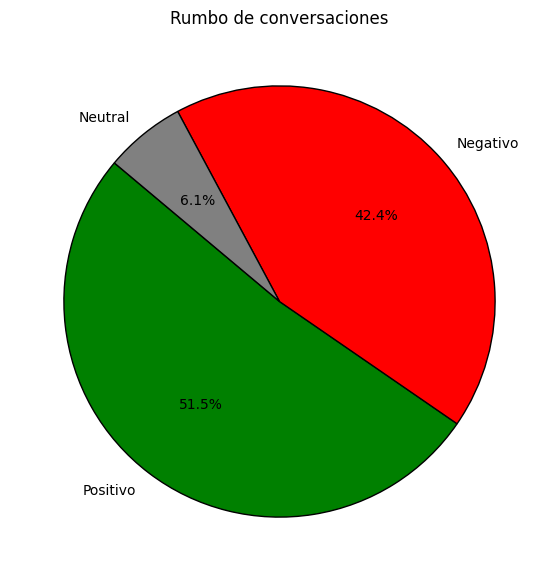

In [164]:
# Definir colores para cada sentimiento
colores = {
    "Positivo": "green",
    "Negativo": "red",
    "Neutral": "gray"
}

# Crear gráfico de pastel
plt.figure(figsize=(7,7))
plt.pie(
    porcentaje_sentimientos, 
    labels=porcentaje_sentimientos.index, 
    autopct='%1.1f%%', 
    colors=[colores[label] for label in porcentaje_sentimientos.index], 
    startangle=140, 
    wedgeprops={"edgecolor": "black"}
)

# Título del gráfico
plt.title("Rumbo de conversaciones")

# Mostrar gráfico
plt.show()